# Understanding the Effects of Air Quality on Public Health

The dataset for the project was sourced from: https://www.kaggle.com/datasets/rabieelkharoua/air-quality-and-health-impact-dataset

About Dataset:

This dataset contains comprehensive information on the air quality and its impact on public health for 5,811 records. It includes variables such as air quality index (AQI), concentrations of various pollutants, weather conditions, and health impact metrics. The target variable is the health impact class, which categorizes the health impact based on the air quality and other related factors.

#  Objectives:

In this short study, the we aim to investigate the impact of air quality on public health using a neural network model on a highly imbalanced multi-class dataset. The following concepts can be gleaned from this study:
 - Repeated model evaluation using parallelization to avoid fluke results.
 - Using randomized cross validation search to help configure neural network models.
 - Diversifying models using stochastic gradieint with warm restarts which make use of aggressive cycling learning rate schedules.

# Load all libraries:

In [2]:
# import relevant libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from ydata_profiling import ProfileReport
import missingno as msno
import os
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from keras import backend
from functools import partial
from keras.layers import InputLayer
import tensorflow as tf
from warnings import filterwarnings
from IPython.display import display, HTML
from joblib import Parallel, delayed, dump, load
from scipy.stats import reciprocal


# Set the environment variable to turn off oneDNN custom operations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
filterwarnings('ignore')

# User-defined Functions

In [3]:
# load dataset 
class Classification_Data_Extractor(object):
    # constructor
    def __init__(self, filename, target, ID, verbose=True):
        self.filename = filename
        self.target = target
        self.ID = ID
        self.verbose = verbose
    
    # load dataset and remove duplicates
    def load_dataset_dedup(self):
        self.dataset = pd.read_csv(self.filename)
        initial_shape = self.dataset.shape
        self.dataset.drop_duplicates(inplace=True)
        final_shape = self.dataset.shape
        if self.verbose:
            print(f"Loaded dataset with shape: {initial_shape}")
            print(f"Dataset shape after removing duplicates: {final_shape}")
            
    # reduce memory usage
    def reduce_mem_usage(self):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = self.dataset.memory_usage().sum() / 1024**2    
        for col in self.dataset.columns:
            col_type = self.dataset[col].dtypes
            if col_type in numerics:
                c_min = self.dataset[col].min()
                c_max = self.dataset[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        self.dataset[col] = self.dataset[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        self.dataset[col] = self.dataset[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        self.dataset[col] = self.dataset[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        self.dataset[col] = self.dataset[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        self.dataset[col] = self.dataset[col].astype(np.float32)
                    else:
                        self.dataset[col] = self.dataset[col].astype(np.float64)    
        end_mem = self.dataset.memory_usage().sum() / 1024**2
        if self.verbose: 
            print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    # show target class distribution
    def target_ditribution(self):
        self.dataset[self.target].astype(int)
        print(30 * '---')
        print("Target class distribution")
        return print((self.dataset.groupby(['HealthImpactClass'])['RecordID'].nunique() / len(self.dataset)).apply(lambda p: f'{p:.3%}'))

    def disp_side_by_side(*dataframes):
        html = '<div style="display:flex">'
        non_empty_dfs = [df for df in dataframes if not df.empty]
        if len(non_empty_dfs) == 1:
            dataframe = non_empty_dfs[0]
            html += '<div style="margin-right: 2em">'
            html += dataframe.to_html()
            html += '</div>'
        elif len(non_empty_dfs) > 1:
            for dataframe in non_empty_dfs:
                html += '<div style="margin-right: 2em">'
                html += dataframe.to_html()
                html += '</div>'
        html += '</div>'
        display(HTML(html))
    
    # display univariate summary statistics
    def summary_stats_analyzer(self):
        try:
            df1 = self.dataset.describe(include=['object', 'bool'])
        except ValueError:
            df1 = pd.DataFrame({'Note': ['No object or bool columns present']})
        df2 = self.dataset.describe()
        return disp_side_by_side(df1, df2)
      
    # get the dataset
    def get_dataset(self):
        return self.dataset
    
# summarise value counts and percentage of examples in each class
def summarise_target(y):
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    # summarise the value counts for each class label
    counter = Counter(y)
    # summarise class distribution
    for k, v in counter.items():
        per = v / len(y) * 100
        print(f'Class={k}, Count={v}, Percentage={per:.3f}%')
    
# perform train, validation and test split: https://www.analyticsvidhya.com/blog/2023/11/train-test-validation-split/
def stratified_train_val_test_split(X, y, frac_train=0.6, frac_val=0.2, frac_test=0.2, random_state=None, verbose=True):
    if frac_train + frac_val + frac_test != 1:
        raise ValueError(f'{frac_train:.2f}, {frac_val:.2f}, and {frac_test:.2f}  do not add up to 1.0')
        
    # split into train and temp dataset
    X_train, X_temp, y_train, y_temp = train_test_split(X, 
                                                        y, 
                                                        test_size=(1 - frac_train),
                                                        random_state=random_state, 
                                                        stratify=y)
    # split temp datasets into val and test dataset
    relative_frac_test = frac_test / (frac_test + frac_val)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                    y_temp, 
                                                    test_size=relative_frac_test, 
                                                    random_state=random_state, 
                                                    stratify=y_temp)
    
    assert len(X) == len(X_train) + len(X_val) + len(X_test)
    
    # Check the class distribution
    if verbose:
        print("Class distribution in validation set:\n", summarise_target(y_train))
        print("Class distribution in validation set:\n", summarise_target(y_val))
        print("Class distribution in test set:\n", summarise_target(y_test))
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Data Extraction and EDA

In [4]:
filename = 'air_quality_health_impact_data.csv'
target = 'HealthImpactClass'
ID = 'RecordID'
extractor = Classification_Data_Extractor(filename, target, ID)
extractor.load_dataset_dedup()
extractor.reduce_mem_usage()
extractor.target_ditribution()
# extractor.summary_stats_analyzer()
del ID

Loaded dataset with shape: (5811, 15)
Dataset shape after removing duplicates: (5811, 15)
Mem. usage decreased to  0.27 Mb (59.2% reduction)
------------------------------------------------------------------------------------------
Target class distribution
HealthImpactClass
0.0    82.740%
1.0     9.964%
2.0     4.698%
3.0     1.635%
4.0     0.964%
Name: RecordID, dtype: object


In [5]:
dataset = extractor.get_dataset()
dataset.drop(['RecordID'], axis=1, inplace=True)

In [6]:
os.makedirs('AirQuality_EDA', exist_ok=True)
profile = ProfileReport(dataset)
profile.to_file('AirQuality_EDA/profile_output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Develop and Evaluate Model
## Developing a test harness:

In [6]:
# set random seed for reproducibility
seed = 42
np.random.seed(seed)

In [7]:
# load data for modelling
def get_data(data, target):
    df = data.copy()
    # split data into input (X) and output variable (y)
    X = df[df.columns.difference([target])].values
    y = df[target].values
    del df
    return X, y

def transform_target(y):
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    # encode target to be integers
    y = LabelEncoder().fit_transform(y)
    # one-hot encode output
    y = to_categorical(y)
    return y


def evaluate_model_once(input_dim, output_dim, X_train, y_train, X_val, y_val, n_epochs, batch_size):
    model = create_model(input_dim, output_dim)
    # Fit model
    model.fit(X_train, y_train, epochs=n_epochs, verbose=0, batch_size=batch_size)
    # Evaluate the model
    y_val = transform_target(y_val)
    _, train_score = model.evaluate(X_train, y_train, verbose=0)
    _, val_score = model.evaluate(X_val, y_val, verbose=0)
    return train_score, val_score

def repeated_model_evaluation(input_dim, output_dim, X_train, y_train, X_val, y_val, n_repeats, n_epochs, batch_size,  verbose=True, n_jobs=-1):
    repeated_scores = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_model_once)(input_dim, output_dim, X_train, y_train, X_val, y_val, n_epochs, batch_size) for _ in range(n_repeats)
    )

    # Summarize results
    train_scores = np.array([score[0] for score in repeated_scores])
    val_scores = np.array([score[1] for score in repeated_scores])

    train_avg, train_std = np.mean(train_scores), np.std(train_scores)
    val_avg, val_std = np.mean(val_scores), np.std(val_scores)

    # Print results
    if verbose:
        for train_score, val_score in repeated_scores:
            print(f'> Train={train_score:f}, val={val_score:f}')
        print(f'Train: {train_avg:f} ({train_std:f}), Val: {val_avg:f} ({val_std:f})')
            
# monitor the learning rate
class LearningRateMonitor(Callback):
    # start of training
    def on_train_begin(self, logs={}):
        self.lrates = list()
    # end of each training epoch
    def on_epoch_end(self, epoch, logs={}):
        # get and store the learning rate
        optimizer = self.model.optimizer
        lrate = float(backend.get_value(optimizer.lr))
        self.lrates.append(lrate)

## Load Modeling Data

In [8]:
# load modelling data
X, y = get_data(dataset, target) 

# split into train, validation, test
X_train, y_train, X_val, y_val, X_test, y_test= stratified_train_val_test_split(X, y, random_state=seed, verbose=True)

# apply transformation to train and validation datasets for modelling purposes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# one-hot encode target
y_train = transform_target(y_train)

# instantiate input and output size
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

Class=1.0, Count=347, Percentage=9.954%
Class=0.0, Count=2884, Percentage=82.731%
Class=3.0, Count=57, Percentage=1.635%
Class=4.0, Count=34, Percentage=0.975%
Class=2.0, Count=164, Percentage=4.705%
Class distribution in validation set:
 None
Class=0.0, Count=962, Percentage=82.788%
Class=4.0, Count=11, Percentage=0.947%
Class=3.0, Count=19, Percentage=1.635%
Class=2.0, Count=54, Percentage=4.647%
Class=1.0, Count=116, Percentage=9.983%
Class distribution in validation set:
 None
Class=0.0, Count=962, Percentage=82.717%
Class=2.0, Count=55, Percentage=4.729%
Class=1.0, Count=116, Percentage=9.974%
Class=3.0, Count=19, Percentage=1.634%
Class=4.0, Count=11, Percentage=0.946%
Class distribution in test set:
 None


## Evaluating Baseline Model:

In [59]:
def create_model(input_dim, output_dim):
    # create model
    model = Sequential()
    model.add(InputLayer(input_shape=(input_dim,)))
    model.add(Dense(13, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(output_dim, kernel_initializer='he_uniform', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

# perform repeated evaluation
n_repeats = 30
n_epochs = 200
batch_size = 32
repeated_model_evaluation(input_dim, 
                          output_dim, 
                          X_train, 
                          y_train, 
                          X_val, 
                          y_val, 
                          n_repeats, 
                          n_epochs,
                          batch_size,
                          verbose=True, 
                          n_jobs=-1)

> Train=0.946931, val=0.930293
> Train=0.942914, val=0.933735
> Train=0.940046, val=0.929432
> Train=0.943201, val=0.931153
> Train=0.943488, val=0.930293
> Train=0.943488, val=0.930293
> Train=0.941767, val=0.927711
> Train=0.941480, val=0.935456
> Train=0.941767, val=0.930293
> Train=0.943201, val=0.931153
> Train=0.942628, val=0.938038
> Train=0.946931, val=0.925129
> Train=0.936890, val=0.930293
> Train=0.940046, val=0.927711
> Train=0.942628, val=0.934596
> Train=0.943488, val=0.926850
> Train=0.944923, val=0.931153
> Train=0.943201, val=0.926850
> Train=0.941767, val=0.936317
> Train=0.942341, val=0.932874
> Train=0.943775, val=0.931153
> Train=0.943488, val=0.926850
> Train=0.945209, val=0.929432
> Train=0.940620, val=0.932014
> Train=0.942628, val=0.922547
> Train=0.944349, val=0.934596
> Train=0.944062, val=0.937177
> Train=0.941767, val=0.932874
> Train=0.943775, val=0.932014
> Train=0.940333, val=0.932014
Train: 0.942771 (0.001999), Val: 0.931010 (0.003493)


# Randomised Search for Model Parameters

In [10]:
# Define model creation function
def create_model(n_layers=1, nodes=15, learning_rate=0.01, momentum=0.9):
    # define model
    model = Sequential()
    model.add(InputLayer(input_shape=(input_dim,)))
    for _ in range(1, n_layers):
        model.add(Dense(nodes, kernel_initializer='he_uniform', activation='relu'))
        model.add(BatchNormalization())
    model.add(Dense(output_dim, kernel_initializer='he_uniform', activation='softmax'))
    # compile model
    opt = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define hyperparameter space
param_distribs = {
    'n_layers': list(np.arange(1, 11, 1)),
    'nodes': np.arange(5, 15, 1),
    'learning_rate': reciprocal(1e-6, 1e-1),
    'momentum': np.linspace(0.9, 0.99, 50),
    'epochs': np.arange(50, 300, 50),
    'batch_size': [16, 32, 64],
}

# Create a KerasClassifier
model = KerasClassifier(model=create_model, 
                        n_layers=1, 
                        nodes=15, 
                        learning_rate=0.01, 
                        momentum=0.9, 
                        verbose=0)

# Define evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Evaluate the model with RandomizedSearchCV
rnd_search_cv = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_distribs, 
                                   n_iter=10, 
                                   n_jobs=-1, 
                                   cv=cv)

rnd_search_cv_result = rnd_search_cv.fit(X_train, y_train)

print('Best score %f using %s' % (rnd_search_cv_result.best_score_, rnd_search_cv_result.best_params_))
means = rnd_search_cv_result.cv_results_['mean_test_score']
stds = rnd_search_cv_result.cv_results_['std_test_score']
params = rnd_search_cv_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) using %r' % (mean, stdev, param))

Best score 0.943205 using {'batch_size': 64, 'epochs': 250, 'learning_rate': 0.00444662895547545, 'momentum': 0.9716326530612245, 'n_layers': 6, 'nodes': 7}
0.940621 (0.009658) using {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.029794544625913636, 'momentum': 0.9238775510204081, 'n_layers': 8, 'nodes': 11}
0.924554 (0.011071) using {'batch_size': 16, 'epochs': 250, 'learning_rate': 8.777815504719649e-05, 'momentum': 0.9312244897959184, 'n_layers': 5, 'nodes': 12}
0.852831 (0.015130) using {'batch_size': 32, 'epochs': 50, 'learning_rate': 2.539057572102415e-05, 'momentum': 0.9808163265306122, 'n_layers': 9, 'nodes': 5}
0.891882 (0.052159) using {'batch_size': 16, 'epochs': 50, 'learning_rate': 0.007264803074826736, 'momentum': 0.9789795918367347, 'n_layers': 8, 'nodes': 12}
0.604143 (0.080990) using {'batch_size': 64, 'epochs': 150, 'learning_rate': 9.867611000082876e-06, 'momentum': 0.9128571428571429, 'n_layers': 3, 'nodes': 7}
0.825878 (0.012769) using {'batch_size': 16, 'epo

In [37]:
best_params = rnd_search_cv_result.best_params_
best_params_df = pd.DataFrame([best_params])
best_params_df.to_csv('best_params.csv', index=False)

In [35]:
# Extract each parameter
n_layers = best_params_df['n_layers'].iloc[0]
nodes = best_params_df['nodes'].iloc[0]
learning_rate = best_params_df['learning_rate'].iloc[0]
momentum = best_params_df['momentum'].iloc[0]
n_epochs = best_params_df['epochs'].iloc[0]
batch_size = best_params_df['batch_size'].iloc[0]

# Print the extracted parameters
print(f'n_layers: {n_layers}')
print(f'nodes: {nodes}')
print(f'learning_rate: {learning_rate}')
print(f'momentum: {momentum}')
print(f'epochs: {epochs}')
print(f'batch_size: {batch_size}')

n_layers: 6
nodes: 7
learning_rate: 0.00444662895547545
momentum: 0.9716326530612245
epochs: 250
batch_size: 64


In [36]:
# evaluate baseline model using Focal Loss: https://amaarora.github.io/posts/2020-06-29-FocalLoss.html
def create_model(input_dim, output_dim):
    # create model
    model = Sequential()
    model.add(InputLayer(input_shape=(input_dim,)))
    for _ in range(1, n_layers):
        model.add(Dense(nodes, kernel_initializer='he_uniform', activation='relu'))
        model.add(BatchNormalization())
    opt = SGD(learning_rate=learning_rate, momentum=momentum)
    model.add(Dense(output_dim, kernel_initializer='he_uniform', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# perform repeated evaluation
n_repeats = 30
n_epochs = n_epochs
batch_size = batch_size
repeated_model_evaluation(input_dim, 
                          output_dim, 
                          X_train, 
                          y_train, 
                          X_val, 
                          y_val, 
                          n_repeats, 
                          n_epochs,
                          batch_size,
                          verbose=True, 
                          n_jobs=-1)

> Train=0.952955, val=0.944923
> Train=0.944062, val=0.938038
> Train=0.950086, val=0.940620
> Train=0.955250, val=0.949225
> Train=0.952955, val=0.944923
> Train=0.957831, val=0.948365
> Train=0.954389, val=0.944062
> Train=0.955250, val=0.946644
> Train=0.956971, val=0.948365
> Train=0.957831, val=0.942341
> Train=0.956971, val=0.938898
> Train=0.958692, val=0.950947
> Train=0.958118, val=0.945783
> Train=0.955536, val=0.945783
> Train=0.954102, val=0.946644
> Train=0.955250, val=0.944062
> Train=0.950086, val=0.935456
> Train=0.950086, val=0.932874
> Train=0.958692, val=0.945783
> Train=0.956971, val=0.946644
> Train=0.955250, val=0.941480
> Train=0.952094, val=0.940620
> Train=0.955250, val=0.946644
> Train=0.956110, val=0.950947
> Train=0.955823, val=0.950947
> Train=0.952381, val=0.946644
> Train=0.956684, val=0.946644
> Train=0.948652, val=0.940620
> Train=0.958979, val=0.947504
> Train=0.946644, val=0.945783
Train: 0.954332 (0.003649), Val: 0.944607 (0.004357)


# Constructing an Ensemble model

Repeat 1/30
> saved snapshot snapshot_model_1.keras, epoch 24
> saved snapshot snapshot_model_2.keras, epoch 49
> saved snapshot snapshot_model_3.keras, epoch 74
> saved snapshot snapshot_model_4.keras, epoch 99
> saved snapshot snapshot_model_5.keras, epoch 124
> saved snapshot snapshot_model_6.keras, epoch 149
> saved snapshot snapshot_model_7.keras, epoch 174
> saved snapshot snapshot_model_8.keras, epoch 199
> saved snapshot snapshot_model_9.keras, epoch 224
> saved snapshot snapshot_model_10.keras, epoch 249
> loaded snapshot_model_1.keras
> loaded snapshot_model_2.keras
> loaded snapshot_model_3.keras
> loaded snapshot_model_4.keras
> loaded snapshot_model_5.keras
> loaded snapshot_model_6.keras
> loaded snapshot_model_7.keras
> loaded snapshot_model_8.keras
> loaded snapshot_model_9.keras
> loaded snapshot_model_10.keras
Loaded 10 models
> 1: single=0.950947, ensemble=0.950947
> 2: single=0.948365, ensemble=0.949225
> 3: single=0.946644, ensemble=0.949225
> 4: single=0.941480, e

> loaded snapshot_model_6.keras
> loaded snapshot_model_7.keras
> loaded snapshot_model_8.keras
> loaded snapshot_model_9.keras
> loaded snapshot_model_10.keras
Loaded 10 models
> 1: single=0.947504, ensemble=0.947504
> 2: single=0.947504, ensemble=0.948365
> 3: single=0.943201, ensemble=0.948365
> 4: single=0.932874, ensemble=0.947504
> 5: single=0.950947, ensemble=0.948365
> 6: single=0.944062, ensemble=0.948365
> 7: single=0.947504, ensemble=0.950086
> 8: single=0.934596, ensemble=0.948365
> 9: single=0.945783, ensemble=0.949225
> 10: single=0.937177, ensemble=0.948365
Repeat 8/30
> saved snapshot snapshot_model_1.keras, epoch 24
> saved snapshot snapshot_model_2.keras, epoch 49
> saved snapshot snapshot_model_3.keras, epoch 74
> saved snapshot snapshot_model_4.keras, epoch 99
> saved snapshot snapshot_model_5.keras, epoch 124
> saved snapshot snapshot_model_6.keras, epoch 149
> saved snapshot snapshot_model_7.keras, epoch 174
> saved snapshot snapshot_model_8.keras, epoch 199
> sav

> saved snapshot snapshot_model_2.keras, epoch 49
> saved snapshot snapshot_model_3.keras, epoch 74
> saved snapshot snapshot_model_4.keras, epoch 99
> saved snapshot snapshot_model_5.keras, epoch 124
> saved snapshot snapshot_model_6.keras, epoch 149
> saved snapshot snapshot_model_7.keras, epoch 174
> saved snapshot snapshot_model_8.keras, epoch 199
> saved snapshot snapshot_model_9.keras, epoch 224
> saved snapshot snapshot_model_10.keras, epoch 249
> loaded snapshot_model_1.keras
> loaded snapshot_model_2.keras
> loaded snapshot_model_3.keras
> loaded snapshot_model_4.keras
> loaded snapshot_model_5.keras
> loaded snapshot_model_6.keras
> loaded snapshot_model_7.keras
> loaded snapshot_model_8.keras
> loaded snapshot_model_9.keras
> loaded snapshot_model_10.keras
Loaded 10 models
> 1: single=0.947504, ensemble=0.947504
> 2: single=0.939759, ensemble=0.948365
> 3: single=0.948365, ensemble=0.949225
> 4: single=0.950086, ensemble=0.950947
> 5: single=0.950086, ensemble=0.950947
> 6: 

> loaded snapshot_model_8.keras
> loaded snapshot_model_9.keras
> loaded snapshot_model_10.keras
Loaded 10 models
> 1: single=0.944062, ensemble=0.944062
> 2: single=0.945783, ensemble=0.945783
> 3: single=0.946644, ensemble=0.946644
> 4: single=0.941480, ensemble=0.945783
> 5: single=0.943201, ensemble=0.944923
> 6: single=0.931153, ensemble=0.946644
> 7: single=0.944923, ensemble=0.946644
> 8: single=0.944062, ensemble=0.946644
> 9: single=0.950947, ensemble=0.946644
> 10: single=0.937177, ensemble=0.947504
Repeat 21/30
> saved snapshot snapshot_model_1.keras, epoch 24
> saved snapshot snapshot_model_2.keras, epoch 49
> saved snapshot snapshot_model_3.keras, epoch 74
> saved snapshot snapshot_model_4.keras, epoch 99
> saved snapshot snapshot_model_5.keras, epoch 124
> saved snapshot snapshot_model_6.keras, epoch 149
> saved snapshot snapshot_model_7.keras, epoch 174
> saved snapshot snapshot_model_8.keras, epoch 199
> saved snapshot snapshot_model_9.keras, epoch 224
> saved snapshot 

> saved snapshot snapshot_model_4.keras, epoch 99
> saved snapshot snapshot_model_5.keras, epoch 124
> saved snapshot snapshot_model_6.keras, epoch 149
> saved snapshot snapshot_model_7.keras, epoch 174
> saved snapshot snapshot_model_8.keras, epoch 199
> saved snapshot snapshot_model_9.keras, epoch 224
> saved snapshot snapshot_model_10.keras, epoch 249
> loaded snapshot_model_1.keras
> loaded snapshot_model_2.keras
> loaded snapshot_model_3.keras
> loaded snapshot_model_4.keras
> loaded snapshot_model_5.keras
> loaded snapshot_model_6.keras
> loaded snapshot_model_7.keras
> loaded snapshot_model_8.keras
> loaded snapshot_model_9.keras
> loaded snapshot_model_10.keras
Loaded 10 models
> 1: single=0.949225, ensemble=0.949225
> 2: single=0.948365, ensemble=0.949225
> 3: single=0.948365, ensemble=0.948365
> 4: single=0.944923, ensemble=0.949225
> 5: single=0.948365, ensemble=0.949225
> 6: single=0.949225, ensemble=0.949225
> 7: single=0.946644, ensemble=0.948365
> 8: single=0.946644, ens

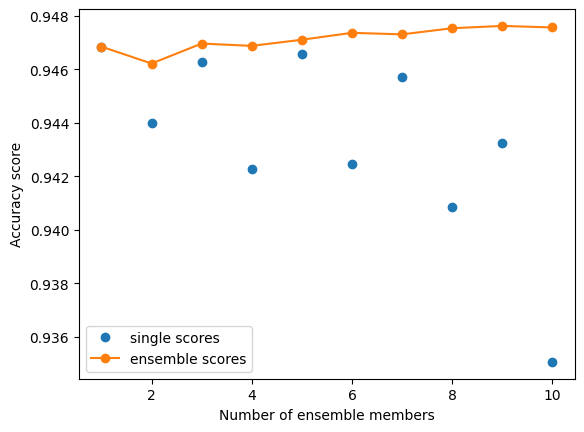

In [38]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import numpy as np
import math
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import backend
from keras.callbacks import Callback
import matplotlib.pyplot as plt

# Snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
    # Constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.n_epochs = n_epochs
        self.n_cycles = n_cycles
        self.lrate_max = lrate_max
        self.lrates = list()
        self.epoch_batches = 0
        self.batch = 0

    # Calculate learning rate for each batch
    def cosine_annealing(self, batch, epoch_batches, n_cycles, lrate_max):
        batches_per_cycle = epoch_batches * n_cycles
        cos_inner = (math.pi * (batch % batches_per_cycle)) / batches_per_cycle
        return lrate_max / 2 * (math.cos(cos_inner) + 1)

    # Calculate and set learning rate at the start of each batch
    def on_train_begin(self, logs=None):
        self.epoch_batches = self.params['steps']

    def on_batch_begin(self, batch, logs=None):
        # Calculate learning rate
        lr = self.cosine_annealing(self.batch, self.epoch_batches, self.n_cycles, self.lrate_max)
        backend.set_value(self.model.optimizer.learning_rate, lr)
        # Log value
        self.lrates.append(lr)
        self.batch += 1

    # Save model at the end of each cycle
    def on_epoch_end(self, epoch, logs=None):
        # Check if we can save model
        epochs_per_cycle = math.floor(self.n_epochs / self.n_cycles)
        if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
            # Save model to file
            filename = 'snapshot_model_%d.keras' % int((epoch + 1) / epochs_per_cycle)
            self.model.save(filename)
            print('> saved snapshot %s, epoch %d' % (filename, epoch))

# Load model from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'snapshot_model_' + str(i + 1) + '.keras'
        model = load_model(filename)
        all_models.append(model)
        print('> loaded %s' % filename)
    return all_models

# Make an ensemble prediction for multiclass classification
def ensemble_predictions(members, testX):
    yhats = [model.predict(testX, verbose=0) for model in members]
    yhats = np.array(yhats)
    summed = np.sum(yhats, axis=0)
      result = np.argmax(summed, axis=1)
    return result

# Evaluate a specific number of members in an ensemble
def evaluate_n_ensembles(members, n_members, testX, testy):
    subset = members[:n_members]
    yhat = ensemble_predictions(subset, testX)
    return accuracy_score(testy, yhat)

# Repeat evaluation process 30 times
n_repeats = 30
all_single_scores = []
all_ensemble_scores = []

for repeat in range(n_repeats):
    print(f'Repeat {repeat + 1}/{n_repeats}')
    
    # define model
    model = Sequential()
    model.add(InputLayer(input_shape=(input_dim,)))
    for _ in range(1, n_layers):
        model.add(Dense(nodes, kernel_initializer='he_uniform', activation='relu'))
        model.add(BatchNormalization())
    opt = SGD(learning_rate=learning_rate, momentum=momentum)
    model.add(Dense(output_dim, kernel_initializer='he_uniform', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Define learning rate callback
    n_epochs = n_epochs
    n_cycles = 10
    ca = SnapshotEnsemble(n_epochs, n_cycles, 0.01)

    # Fit model
    model.fit(X_train, y_train, epochs=n_epochs, verbose=0, batch_size=batch_size, callbacks=[ca])

    # Load models in order
    members = load_all_models(10)
    print('Loaded %d models' % len(members))

    # Reverse loaded models so we build the ensemble with the last models first
    members = list(reversed(members))

    # Evaluate different members of ensembles on holdout set
    single_scores, ensemble_scores = list(), list()
    for i in range(1, len(members) + 1):
        # Evaluate model with i members
        ensemble_score = evaluate_n_ensembles(members, i, X_val, y_val)
        # Evaluate the i'th model standalone
        y_val_enc = transform_target(y_val)
        _, single_score = members[i-1].evaluate(X_val, y_val_enc, verbose=0)
        # Summarize this step
        print('> %d: single=%f, ensemble=%f' % (i, single_score, ensemble_score))
        ensemble_scores.append(ensemble_score)
        single_scores.append(single_score)

    all_single_scores.append(single_scores)
    all_ensemble_scores.append(ensemble_scores)

# Summarize expected accuracy of a single final model
all_single_scores = np.array(all_single_scores)
all_ensemble_scores = np.array(all_ensemble_scores)

print('Single Model Accuracy: %f (%f)' % (np.mean(all_single_scores), np.std(all_single_scores)))
print('Ensemble Model Accuracy: %f (%f)' % (np.mean(all_ensemble_scores), np.std(all_ensemble_scores)))

# Plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members) + 1)]
mean_single_scores = np.mean(all_single_scores, axis=0)
mean_ensemble_scores = np.mean(all_ensemble_scores, axis=0)
plt.plot(x_axis, mean_single_scores, marker='o', linestyle='None', label='single scores')
plt.plot(x_axis, mean_ensemble_scores, marker='o', label='ensemble scores')
plt.xlabel('Number of ensemble members')
plt.ylabel('Accuracy score')
plt.legend()
# Show plot
plt.show()

In [42]:
n_members = np.argmax(mean_ensemble_scores)
# make prediction on the test data and evaluate
def evaluate_ensembles(members, n_members, testX, testy):
    subset = members[:n_members]
    yhat = ensemble_predictions(members, testX)
    return accuracy_score(testy, yhat)

test_score = evaluate_ensembles(members, n_members, X_test, y_test)
print('Test Acccuracy %f' % test_score)

Test Acccuracy 0.956148


# Where do we go from here?

We have shown that employing snapshot ensembles leads to enhanced stability in performance and better generalization.
For this brief study, we achieved an accuracy of 95.6%, which is satisfactory and comparable to the results obtained by other Kaggle projects.
There is still room for experimentation, and I believe accuracy can be improved further by investigating other ensemble methods.